![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 053</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">Funnel-Base-ConcatLayer</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [1]:
import sys
sys.path.append("../src/utils/iterative-stratification/")
sys.path.append("../src/utils/detoxify")
sys.path.append("../src/utils/coral-pytorch/")
sys.path.append("../src/utils/pyspellchecker")

In [2]:
!pip install --no-index --find-links ../src/utils/faiss/ faiss-gpu==1.6.3

Looking in links: ../src/utils/faiss/


In [4]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, AutoModelForSequenceClassification
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import LukeTokenizer, LukeModel, LukeConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import DebertaTokenizer, DebertaModel
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import FunnelTokenizer, FunnelBaseModel

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from cuml.svm import SVR as cuml_SVR
from cuml.linear_model import Ridge as cuml_Ridge
import cudf
from detoxify import Detoxify
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from ast import literal_eval
from nltk.tokenize import TweetTokenizer
import spacy
from scipy.stats import sem
from copy import deepcopy
from spellchecker import SpellChecker
from typing import Text, Set, List

import faiss
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer as cuTfidfVectorizer
from cuml.neighbors import NearestNeighbors as cuNearestNeighbors
from cuml.decomposition.tsvd import TruncatedSVD as cuTruncatedSVD
from cuml.decomposition.pca import PCA as cuPCA

In [9]:
import torch

config = {
    "exp_comment":"Psuedo Labeling",
    "seed": 0,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 256,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "053_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": True,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 8,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 2,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 2,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "funnel-transformer/medium-base",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-6,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MarginRankingLoss",
}

config = Box(config)
config.tokenizer = FunnelTokenizer.from_pretrained(config.backbone.name)
config.model = FunnelBaseModel.from_pretrained(config.backbone.name)
# pprint(config)

In [10]:
config.tokenizer.save_pretrained(f"../data/processed/{config.backbone.name}")
pretrain_model = FunnelBaseModel.from_pretrained(config.backbone.name)
pretrain_model.save_pretrained(f"../data/processed/{config.backbone.name}")

In [11]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/053_exp
OUTPUT_DIR is ../data/interim/053_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [12]:
# Seed固定
seed_everything(config.seed)

0

In [13]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [14]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [15]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [16]:
with timer("Count less text & more text"):
    less_df = val_df.groupby(["less_toxic"])["worker"].agg("count").reset_index()
    less_df.columns = ["text", "less_count"]

    more_df = val_df.groupby(["more_toxic"])["worker"].agg("count").reset_index()
    more_df.columns = ["text", "more_count"]
    
    text_df = pd.merge(
        less_df,
        more_df,
        on="text",
        how="outer"
    )

    text_df["less_count"] = text_df["less_count"].fillna(0)
    text_df["more_count"] = text_df["more_count"].fillna(0)
    
    text_df["target"] = text_df["more_count"]/(text_df["less_count"] + text_df["more_count"])
    
    display(text_df)

<< Count less text & more text >> Start


,text,less_count,more_count,target
0,\n\nThe comment directly above this one are fr...,1.0,2.0,0.666667
1,\n\nwhy should people have to read crap posted...,1.0,8.0,0.888889
2,\nGo F yourself you cottonheadednittymuggins.,1.0,2.0,0.666667
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",3.0,0.0,0.000000
4,\n\n koreans claim \n\ni see youve seen the ...,4.0,2.0,0.333333
...,...,...,...,...
14246,{{unblock|The reason I used sockpuppets was to...,0.0,3.0,1.000000
14247,{{unblock}} BECAUSE BAIL OUT IS THE BEST FUCK...,0.0,3.0,1.000000
14248,|Christopher Connor]]. I am off to my daily ma...,0.0,6.0,1.000000
14249,}} \n\nSomeone should address this fucking pro...,0.0,1.0,1.000000


<< Count less text & more text >> 3.0GB(+0.0GB):0.1sec


<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Make Fold
</h1>
<br>

In [17]:
texts = set(val_df["less_toxic"].to_list() + val_df["more_toxic"].to_list())
text2id = {t:id for id,t in enumerate(texts)}
val_df['less_id'] = val_df['less_toxic'].map(text2id)
val_df['more_id'] = val_df['more_toxic'].map(text2id)
val_df.head()

,worker,less_toxic,more_toxic,less_id,more_id
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,5019,12502
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,2866,12816
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",2713,9313
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,2621,11662
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",6064,8121


In [18]:
len_ids = len(text2id)
idarr = np.zeros((len_ids, len_ids), dtype=bool)

for lid, mid in val_df[['less_id', 'more_id']].values:
    min_id = min(lid, mid)
    max_id = max(lid, mid)
    idarr[max_id, min_id] = True

In [19]:
def add_ids(i, this_list):
    for j in range(len_ids):
        if idarr[i, j]:
            idarr[i, j] = False
            this_list.append(j)
            this_list = add_ids(j,this_list)
            #print(j,i)
    for j in range(i+1,len_ids):
        if idarr[j, i]:
            idarr[j, i] = False
            this_list.append(j)
            this_list = add_ids(j,this_list)
            #print(j,i)
    return this_list

group_list = []
for i in tqdm(range(len_ids)):
    for j in range(i+1,len_ids):
        if idarr[j, i]:
            this_list = add_ids(i,[i])
#             print(this_list)
            group_list.append(this_list)

id2groupid = {}
for gid,ids in enumerate(group_list):
    for id in ids:
        id2groupid[id] = gid

val_df['less_gid'] = val_df['less_id'].map(id2groupid)
val_df['more_gid'] = val_df['more_id'].map(id2groupid)

  0%|          | 0/14251 [00:00<?, ?it/s]

In [20]:
print('unique text counts:', len_ids)
print('grouped text counts:', len(group_list))

unique text counts: 14251
grouped text counts: 4143


In [21]:
# now we can use GroupKFold with group id
group_kfold = GroupKFold(n_splits=config.n_fold)

# Since df.less_gid and df.more_gid are the same, let's use df.less_gid here.
for fold, (trn, val) in enumerate(group_kfold.split(val_df, val_df, val_df.less_gid)): 
    val_df.loc[val , "fold"] = fold

val_df["fold"] = val_df["fold"].astype(int)
val_df

,worker,less_toxic,more_toxic,less_id,more_id,less_gid,more_gid,fold
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,5019,12502,2850,2850,3
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,2866,12816,632,632,2
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",2713,9313,1922,1922,2
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,2621,11662,785,785,2
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",6064,8121,2319,2319,1
...,...,...,...,...,...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,11228,6032,2664,2664,4
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,11228,6032,2664,2664,4
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,8477,1311,1081,1081,3
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,8477,1311,1081,1081,3


In [22]:
val_df.to_csv(OUTPUT_DIR/"val_df.csv", index=False)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Pytorch Dataset
</h1>
<br>

In [18]:
val_df = pd.read_csv(OUTPUT_DIR/"val_df.csv")
display(val_df.head())

,worker,less_toxic,more_toxic,less_id,more_id,less_gid,more_gid,fold
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,12975,7916,1478,1478,3
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,9110,3902,604,604,2
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",724,377,356,356,4
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,8540,9299,228,228,4
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",9227,5952,1736,1736,1


In [28]:
class JigsawDataset:
    
    def __init__(self, df, tokenizer, max_length, mode):
        
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.mode = mode
        
        if self.mode == "train":
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values
            
        elif self.mode == "valid":
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values
            
        else:
            self.text = df["text"].values
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            more_toxic = self.more_toxic[index]
            less_toxic = self.less_toxic[index]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]
            more_token_type_ids = inputs_more_toxic["token_type_ids"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]
            less_token_type_ids = inputs_less_toxic["token_type_ids"]
            
            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'more_token_type_ids': torch.tensor(more_token_type_ids, dtype=torch.long),
                
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'less_token_type_ids': torch.tensor(less_token_type_ids, dtype=torch.long),
                
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        elif self.mode == "valid":
            
            more_toxic = self.more_toxic[index]
            less_toxic = self.less_toxic[index]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]
            more_token_type_ids = inputs_more_toxic["token_type_ids"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]
            less_token_type_ids = inputs_less_toxic["token_type_ids"]
            
            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'more_token_type_ids': torch.tensor(more_token_type_ids, dtype=torch.long),
                
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'less_token_type_ids': torch.tensor(less_token_type_ids, dtype=torch.long),
                
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        else:
            
            text = self.text[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            }

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    DataModule
</h2>
<br>

In [29]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="train",
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="valid",
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df,
            tokenizer = self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="test",
        )

        return DataLoader(dataset, **self._cfg.test_loader)

In [30]:
## DataCheck
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(val_df, val_df, test_df, config).train_dataloader()
for data in sample_dataloader:
    break

In [31]:
print(data["more_toxic_ids"].size())
print(data["more_toxic_mask"].size())
print(data["more_token_type_ids"].size())
print(data["target"].size())
print(data["target"])
output = config.model(
    data["more_toxic_ids"],
    data["more_toxic_mask"],
    data["more_token_type_ids"],
    output_hidden_states=True,
    output_attentions=True,
)
print(output["hidden_states"][-1].size(), output["attentions"][-1].size())
print(output["hidden_states"][-1][:, 1, :].size(), output["attentions"][-1].size())

torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8])
tensor([1., 1., 1., 1., 1., 1., 1., 1.])
torch.Size([8, 64, 768]) torch.Size([8, 12, 64, 64])
torch.Size([8, 768]) torch.Size([8, 12, 64, 64])


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    LigitningModule
</h2>
<br>

In [32]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=config.margin)(outputs1, outputs2, targets)

In [33]:
class JigsawModel(pl.LightningModule):
    
    def __init__(self, cfg, fold_num):
        
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = criterion
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num
        
    def __build_model(self):
        
        self.base_model = FunnelBaseModel.from_pretrained(
            self.cfg.backbone.name
        )
#         print(f"Use Model: {self.cfg.backbone.name}")
        self.norm = nn.LayerNorm(768*4)
        self.drop = nn.Dropout(p=0.3)
        
        self.head = nn.Linear(768*4, self.cfg.backbone.output_dim)
        
    def forward(self, ids, mask, token_type_ids):
        
        output = self.base_model(
            input_ids=ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
        )
        sequence_output = torch.cat(
            [output["hidden_states"][-1*i][:,0] for i in [1, 2, 3, 4]],
            dim=1
        )
        feature = self.norm(sequence_output)
        feature = self.drop(feature)
        out = self.head(feature)

        return {
            "logits":out, 
        }
    
    def training_step(self, batch, batch_idx):
        
        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        more_text_token_type_ids = batch['more_token_type_ids']
        
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        less_text_token_type_ids = batch['less_token_type_ids']
        
        targets = batch['target']
        
        more_outputs = self.forward(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids
        )
        
        less_outputs = self.forward(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        loss = self.criterion(more_outputs["logits"], less_outputs["logits"], targets)

        
        return {
            "loss":loss,
            "targets":targets,
        }
    
    def training_epoch_end(self, training_step_outputs):

        loss_list = []

        for out in training_step_outputs:

            loss_list.extend([out["loss"].cpu().detach().tolist()])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def validation_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        more_text_token_type_ids = batch['more_token_type_ids']
        
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        less_text_token_type_ids = batch['less_token_type_ids']
        
        targets = batch['target']

        more_outputs = self.forward(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids
        )
        
        less_outputs = self.forward(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )

        
        outputs = more_outputs["logits"] - less_outputs["logits"]
        logits = outputs.clone()[:, 0]

        logits[logits > 0] = 1
        loss = nn.BCEWithLogitsLoss()(logits, targets)

        return {
            "loss":loss,
            "pred":outputs,
            "targets":targets,
        }
    
    
    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.append(out["pred"][:, 0].detach().cpu().numpy())
            target_list.append(out["targets"].detach().cpu().numpy())

        meanloss = sum(loss_list)/len(loss_list)
        pred_list = np.concatenate(pred_list)
        pred_count = sum(x>0 for x in pred_list)/len(pred_list)

        logs = {
            f"valid_loss/fold{self.fold_num+1}":meanloss,
            f"valid_acc/fold{self.fold_num+1}":pred_count,
        }

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Training
</h2>
<br>

In [34]:
# skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

# for fold, (_, val_idx) in enumerate(skf.split(X=val_df, y=val_df["worker"])):
#     val_df.loc[val_idx, "kfold"] = int(fold)

# val_df["kfold"] = val_df["kfold"].astype(int)
val_df.head()

,worker,less_toxic,more_toxic,less_id,more_id,less_gid,more_gid,fold
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,5019,12502,2850,2850,3
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,2866,12816,632,632,2
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",2713,9313,1922,1922,2
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,2621,11662,785,785,2
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",6064,8121,2319,2319,1


In [35]:
# ## Debug
# config.trainer.fast_dev_run = True
# config.backbone.output_dim = 1

# for fold in config.train_fold:
    
#     print("★"*25, f" Fold{fold+1} ", "★"*25)

#     df_train = val_df[val_df.fold != fold].reset_index(drop=True)
#     df_valid = val_df[val_df.fold != fold].reset_index(drop=True)

#     datamodule = JigsawDataModule(df_train, df_valid, test_df, config)
#     sample_dataloader = JigsawDataModule(df_train, df_valid, test_df, config).train_dataloader()

#     config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
#     model = JigsawModel(config, fold)
#     lr_monitor = callbacks.LearningRateMonitor()

#     loss_checkpoint = callbacks.ModelCheckpoint(
#         filename=f"best_acc_fold{fold+1}",
#         monitor=f"valid_acc/fold{fold+1}",
#         save_top_k=1,
#         mode="max",
#         save_last=False,
#         dirpath=MODEL_DIR,
#         save_weights_only=True,
#     )

#     wandb_logger = WandbLogger(
#         project=config.project, 
#         entity=config.entity,
#         name = f"{config.exp_name}",
#         tags = ['RoBERTa-Base', "MarginRankLoss"]
#     )

#     lr_monitor = LearningRateMonitor(logging_interval='step')

#     trainer = pl.Trainer(
#         max_epochs=config.epoch,
#         callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
# #         deterministic=True,
#         logger=[wandb_logger],
#         **config.trainer
#     )
#     trainer.fit(model, datamodule=datamodule)

In [ ]:
# Training
config.trainer.fast_dev_run = False
config.backbone.output_dim = 1

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = val_df[val_df.fold != fold].reset_index(drop=True)
    df_valid = val_df[val_df.fold == fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, df_valid, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, df_valid, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['Funnel-Base', "MarginRankLoss", "ConcatLayer"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


wandb: Currently logged in as: dataskywalker (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-02-05 18:09:20.918627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ FunnelBaseModel │  115 M │
│ 1 │ norm       │ LayerNorm       │  6.1 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  3.1 K │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 115 M                                                                      
Non-trainable params: 0                                                                      
Total params: 115 M                                                                          
Total estimated model params size (MB): 462

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━━ 6021/6021 0:22:43 • 0:00:00 8.75it/s loss: 0.394 v_num:    
                                                                       58dq valid_loss/fold1:
                                                                       0.505 valid_acc/fold1:
                                                                       0.636                 
                                                                       train_loss/fold1:     
                                                                       0.054                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ FunnelBaseModel │  115 M │
│ 1 │ norm       │ LayerNorm       │  6.1 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  3.1 K │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 115 M                                                                      
Non-trainable params: 0                                                                      
Total params: 115 M                                                                          
Total estimated model params size (MB): 462

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━━ 6021/6021 0:22:25 • 0:00:00 8.97it/s loss: 0.394 v_num:    
                                                                       58dq valid_loss/fold2:
                                                                       0.507 valid_acc/fold2:
                                                                       0.659                 
                                                                       train_loss/fold2:     
                                                                       0.056                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ FunnelBaseModel │  115 M │
│ 1 │ norm       │ LayerNorm       │  6.1 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  3.1 K │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 115 M                                                                      
Non-trainable params: 0                                                                      
Total params: 115 M                                                                          
Total estimated model params size (MB): 462

Output()

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Inference
</h2>
<br>

In [38]:
text_df = pd.DataFrame()
text_df["text"] = list(set(val_df["less_toxic"].unique().tolist() + val_df["more_toxic"].unique().tolist()))

display(text_df.head())
display(text_df.shape)

,text
0,Secular Humanism - Islam's best friend \n\nI ...
1,"Audi A4\nYOU ARE ASSHOLE, MOTHERFUCKER, SHIT, ..."
2,". Wichert, Boris, whoever you are, you screwed..."
3,"""\n\n August 2008 \n\n""""It includes removing m..."
4,not a crime when everybody can edit it ;)\nhav...


(14251, 1)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device == {device}")

PRED = np.zeros(len(text_df))

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    test_dataloader = JigsawDataModule(val_df, val_df, text_df, config).test_dataloader()
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath="../input/toxicroberta/",
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_acc_fold{fold+1}.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    attention_list = []
    feature_list = []
    mask_list = []
    pred_list = []
    
    for step, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):

        text_ids = data["text_ids"].to(device)
        text_mask = data["text_mask"].to(device)
        text_token_type_ids = data["text_token_type_ids"].to(device)
        
        mask_list.append(text_mask.detach().cpu().numpy())
            
        outputs = model(
            text_ids, 
            text_mask,
            text_token_type_ids,
        )
        
        pred_list.append(outputs["logits"][:, 0].detach().cpu().numpy())

    PRED += np.concatenate(pred_list)/len(config.train_fold)
    
    

Device == cuda
★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


  0%|          | 0/7126 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★


  0%|          | 0/7126 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★


  0%|          | 0/7126 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★


  0%|          | 0/7126 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★


  0%|          | 0/7126 [00:00<?, ?it/s]

In [40]:
text_df["target"] = PRED
text_df.to_pickle(OUTPUT_DIR/f"{config.exp_name}__text_df.pkl")
# np.save(OUTPUT_DIR/'toxic-attention.npy', attention_array)
# np.save(OUTPUT_DIR/'toxic-mask.npy', mask_array)
# np.save(OUTPUT_DIR/'toxic-feature.npy', feature_array)

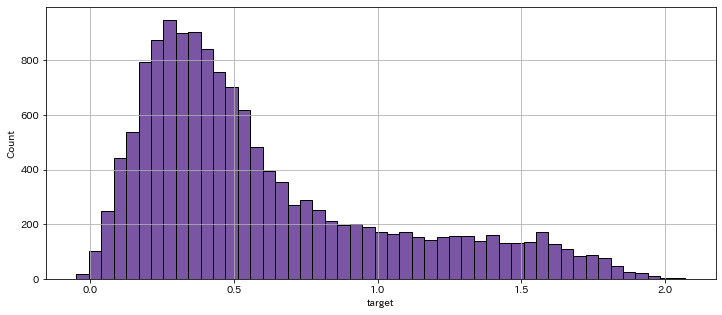

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error resolved after 0:00:57.315279, resuming normal operation.


In [41]:
plt.figure(figsize=(12, 5))
sns.histplot(text_df["target"], color="#4c1c84")
plt.grid()
plt.show()